# 프로젝트 : 폐렴 진단기 성능개선

## Step 1. 실험환경 Set-up

### 라이브러리 불러오기

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

### 변수 설정 및 데이터 로드

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 32
EPOCHS = 20

print(ROOT_PATH)

/aiffel/aiffel


In [3]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


## Step 2. 데이터 준비하기

### 데이터 전처리

In [4]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [5]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


In [6]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [7]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [8]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [9]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [10]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [11]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [12]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


### Augmentation

In [13]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    
    return image,label

def prepare_for_training_aug(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_aug_ds = prepare_for_training_aug(train_ds)
val_aug_ds = prepare_for_training_aug(val_ds)

## Step 3. 데이터 시각화

### Visualization

#### augmentation

(32, 180, 180, 3)
(32,)


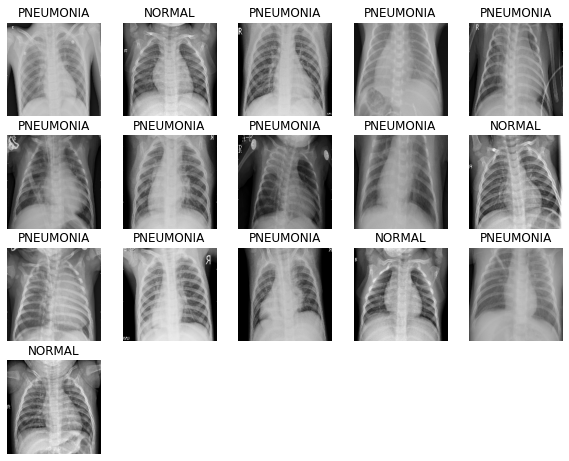

In [14]:
image_aug_batch, label_aug_batch = next(iter(train_aug_ds))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    print(image_batch.shape)
    print(label_batch.shape)
    for n in range(16):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

show_batch(image_aug_batch.numpy(), label_aug_batch.numpy())

## Resnet Model

In [15]:
def residual_block(layer, filters, kernel_size=3, stride=1):
    x = tf.keras.layers.Conv2D(filters, kernel_size, strides=stride, padding='same')(layer)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2D(filters, kernel_size, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # Adding the shortcut (residual connection)
    shortcut = tf.keras.layers.Conv2D(filters, 1, strides=stride, padding='same')(layer)
    shortcut = tf.keras.layers.BatchNormalization()(shortcut)

    x = tf.keras.layers.Add()([x, shortcut])
    x = tf.keras.layers.Activation('relu')(x)
    
    return x

In [16]:
def dense_block(layer, units, dropout_rate=0.5, dropout=True):
    x = tf.keras.layers.Dense(units, activation='relu')(layer)
    x = tf.keras.layers.BatchNormalization()(x)
    if dropout:
        x = tf.keras.layers.Dropout(dropout_rate)(x)
    
    return x

In [17]:
def build_resnet_model():
    input_layer = tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

    x = tf.keras.layers.Conv2D(64, 7, strides=2, activation='relu', padding='same')(input_layer)
    x = tf.keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    # Using residual blocks instead of conv blocks
    x = residual_block(x, 64)
    x = residual_block(x, 64)
    
    x = residual_block(x, 128, stride=2)
    x = residual_block(x, 128)
    
    x = residual_block(x, 256, stride=2)
    x = residual_block(x, 256)
    
    x = residual_block(x, 512, stride=2)
    x = residual_block(x, 512)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    x = dense_block(x, 512, 0.7)
    x = dense_block(x, 128, 0.5)
    x = dense_block(x, 64, 0.3)

    output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=input_layer, outputs=output)

    return model

## Imbalance

In [18]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.96
Weight for class 1: 0.67


## Train

#### resnet, drop out, augmentation


In [19]:
with tf.device('/GPU:0'):
    resnet_model = build_resnet_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    resnet_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [20]:
with tf.device('/GPU:0'):
    history = resnet_model.fit(
        train_aug_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_aug_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/20
130/130 [==============================] - 70s 413ms/step - loss: 0.4341 - accuracy: 0.7897 - precision: 0.9462 - recall: 0.7608 - val_loss: 0.7857 - val_accuracy: 0.7363 - val_precision: 0.7363 - val_recall: 1.0000
Epoch 2/20
130/130 [==============================] - 53s 411ms/step - loss: 0.2366 - accuracy: 0.9137 - precision: 0.9702 - recall: 0.9123 - val_loss: 4.1537 - val_accuracy: 0.4219 - val_precision: 0.9392 - val_recall: 0.2264
Epoch 3/20
130/130 [==============================] - 55s 427ms/step - loss: 0.2052 - accuracy: 0.9339 - precision: 0.9751 - recall: 0.9350 - val_loss: 0.6995 - val_accuracy: 0.7666 - val_precision: 0.9923 - val_recall: 0.6871
Epoch 4/20
130/130 [==============================] - 57s 438ms/step - loss: 0.1663 - accuracy: 0.9413 - precision: 0.9821 - recall: 0.9384 - val_loss: 11.2650 - val_accuracy: 0.3311 - val_precision: 1.0000 - val_recall: 0.0867
Epoch 5/20
130/130 [==============================] - 59s 458ms/step - loss: 0.1636 - accur

In [21]:
loss, acc, prec, rec = resnet_model.evaluate(test_ds)

20/20 [==============================] - 5s 240ms/step - loss: 0.6614 - accuracy: 0.8045 - precision: 0.9136 - recall: 0.7590


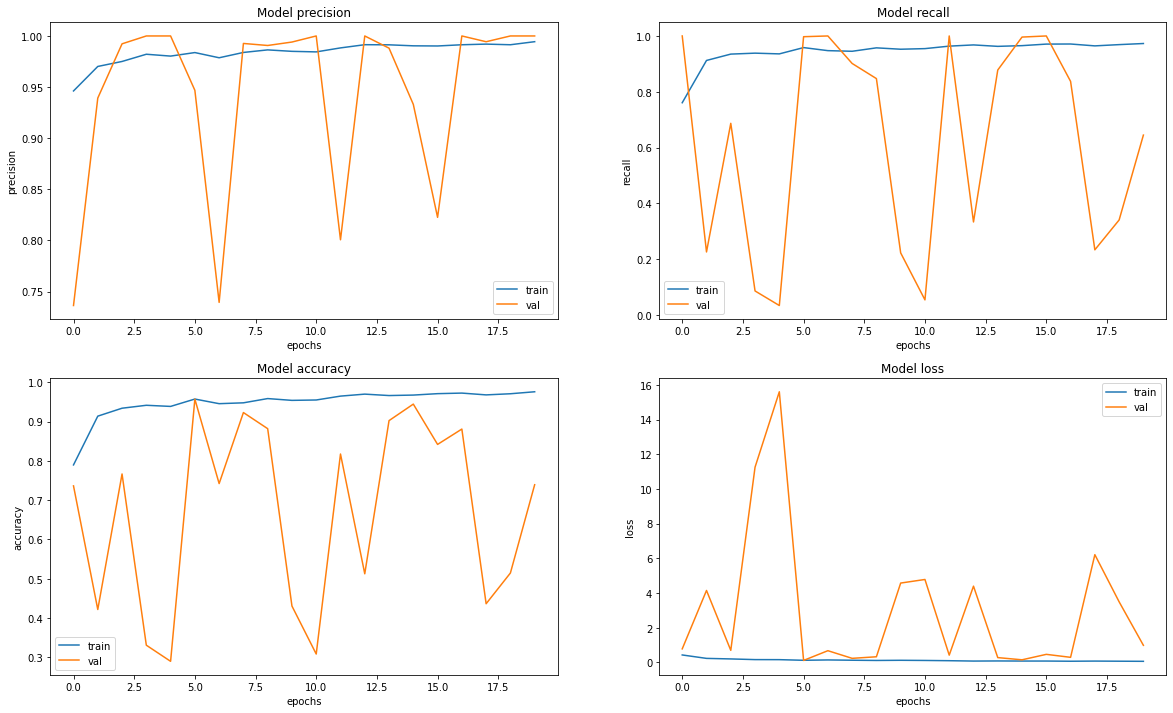

In [22]:
fig, ax = plt.subplots(2, 2, figsize=(20, 12))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

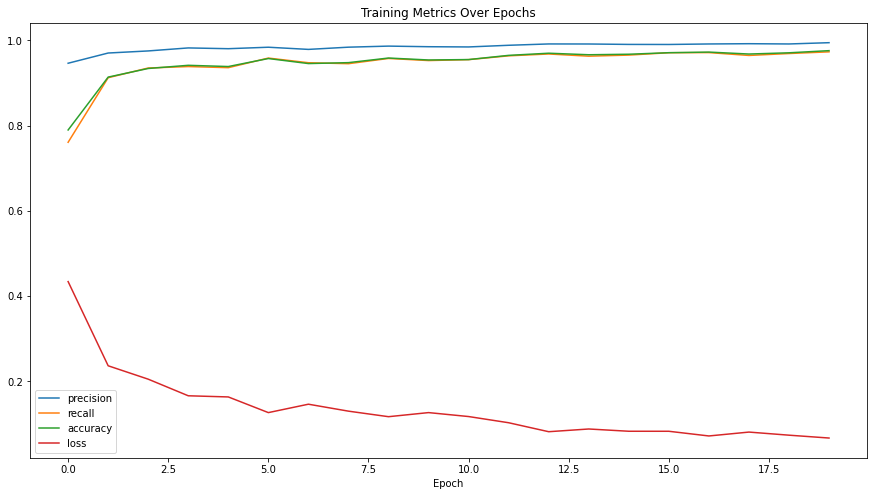

In [23]:
keys = list(history.history.keys())

metrics_to_plot = ['precision', 'recall', 'accuracy', 'loss']

# Plot the specified metrics
plt.figure(figsize=(15, 8))
for metric in metrics_to_plot:
    plt.plot(history.history[metric], label=metric)

plt.title('Training Metrics Over Epochs')
plt.xlabel('Epoch')
plt.legend()
plt.show()


## Ablation study
- Resnet model, epoch(10), batch size(16), dropout(0.5), augmentation(horizontal): Accuracy = 0.746  
- Resnet model, epoch(40), batch size(32), dropout(0.5), augmentation(horizontal): Accuracy = 0.631  
- Resnet model, epoch(20), batch size(32), dropout(0.5), augmentation(horizontal): **Accuracy = 0.8045**  

## 회고
기존 CNN 모델을 Resnet으로 구현하여 학습해보았다. 모델을 만들고 시각화하여 학습 진행 양상을 면밀하게 분석해보았다. Ablation study를 통해 성능이 잘 나오는 하이퍼 파라미터를 셋팅할 수 있었다. 